In [1]:
import geopandas as gpd
import os
import json
import pandas as pd
import tqdm
import math
import numpy as np
import seaborn as sns
from shapely import wkt
import matplotlib.pyplot as plt
import math
import re

In [2]:
plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'axes.titlesize': 13})
plt.rcParams.update({'axes.labelsize': 13})
# size of the numbers on the axes
plt.rcParams.update({'xtick.labelsize': 9})
plt.rcParams.update({'ytick.labelsize': 9})
colors = sns.color_palette('husl', 10)

# Input data

Maria Parajeles from PSL provides the original EV data. Four different predicted EV charging pattern data in 2050 are available. CP is the predicted hourly charging load, PD is the hourly upper power bound, and PU is the hourly lower power bound. FE is the daily flexible charging energy, the sum of allowed deviation from controlled CP to actual CP in data. For CP, PD, and PU, each row is a municipality, and every column corresponds to each hour in the year. For FE, each row is a municipality, and every column corresponds to each day of the year. For these data, 4 steps are done to process the data. 

In [3]:
base_path = os.getcwd()
data_path = os.path.join(base_path, 'EV_input')

In [4]:
muni_geo = gpd.read_file('municipality_boundary.geojson')
zones = gpd.read_file(os.path.join(data_path, 'nine_zones 2.geojson'))

In [5]:
# read the original data
CP = pd.read_csv(os.path.join(data_path, 'CP_y4.csv'), header=None)
FE = pd.read_csv(os.path.join(data_path, 'FE_y4.csv'), header=None)
PD = pd.read_csv(os.path.join(data_path, 'PD_y4.csv'), header=None)
PU = pd.read_csv(os.path.join(data_path, 'PU_y4.csv'), header=None)

# Step 1： BFS number mapping

Since in the EV data provided, the municipalities are represented by names, which is inconsistent with the naming convention for the grids. To improve the data processing efficiency, the BFS number was used to substitute the actual municipality name, following the mapping rules in `nine_zones.geojson`. During the mapping process, we found no EV data for three municipalities: Comunanza Cadenazzo/Monteceneri, Staatswald Galm, and Comunanza Capriasca/Lugano. 

In [6]:
# check if the first column of CP FE PD PU is the same
print('the columns of CP and FE are the same:', all(CP[0]==FE[0]))
print('the columns of CP and PD are the same:', all(CP[0]==PD[0]))
print('the columns of CP and PU are the same:', all(CP[0]==PU[0]))

the columns of CP and FE are the same: True
the columns of CP and PD are the same: True
the columns of CP and PU are the same: True


In [7]:
# print the municipalities that appear in zones file but not in CP file
print('Municipalities that appear in zones file but not in EV file: ', set(zones['NAME']) - set(CP[0]))

Municipalities that appear in zones file but not in EV file:  {'Comunanza Capriasca/Lugano', 'Staatswald Galm', 'Comunanza Cadenazzo/Monteceneri'}


In [8]:
# This function maps zone names in the input data to their corresponding BFS numbers 
# based on a provided zones mapping, ensuring data integrity and reordering columns.
# - It copies the input data to avoid modifying the original.
# - Maps the 'BFS_NUMMER' using the 'NAME' column of the zones DataFrame.
# - Removes the original zone name column, reorders columns, renames 'BFS_NUMMER' to 'BFS', 
#   converts it to integer type, and sorts the data by BFS.
# - Warns the user if there are any NaN values in the resulting BFS column.
# Returns a cleaned and mapped DataFrame.

def map_BFS(data, zones):
    df = data.copy()
    # Maps the 'BFS_NUMMER' using the 'NAME' column of the zones DataFrame.
    df['BFS_NUMMER'] = zones.set_index('NAME').loc[df[0].values].BFS_NUMMER.values
    # The name column, which is column 0, is removed
    df = df.drop(columns=[0])
    # The columns of the dataframe are reodered, such that the BFS_NUMMER column is the first column, followed by the rest of the columns.
    # The following columns are sorted in ascending order according to the time they represent.
    df = df[['BFS_NUMMER'] + [col for col in df.columns if col != 'BFS_NUMMER']]
    # The BFS_NUMMER column is renamed to BFS and converted to integer type.
    df.rename(columns={'BFS_NUMMER': 'BFS'}, inplace=True)
    df['BFS'] = df['BFS'].astype('int')
    # The dataframe is sorted by BFS number in ascending order and the index is reset.
    df = df.sort_values('BFS')
    df.reset_index(drop=True, inplace=True)
    # Sanity check for NaN values in the BFS column.
    if df['BFS'].isna().sum() > 0:
        print('There are NaN values in the BFS_NUMMER column')
    return df

# The BFS numbers are mapped to the input data, to assign the municipalities to the correct zones.
CP_mapped = map_BFS(CP, zones)
FE_mapped = map_BFS(FE, zones)
PD_mapped = map_BFS(PD, zones)
PU_mapped = map_BFS(PU, zones)

# Step 2: File splitting

To minimize data redundancy, we extracted representative weeks for each municipality, considering four representative weeks repeated throughout the year. These profiles are assigned to different months as detailed in the table below. For each municipality, three CSV files are generated: 

- The first file contains the serial number of time profiles (consistent with the serial numbers shown in the table below), the day of the week (1 represents Monday, 2 represents Tuesday, and so on), the hour of the day, and the corresponding values of PD, CP, and PU for each hour.
- The second file includes the serial number of the time profile, the day of the week, and the corresponding FE values for each day.
- The third file contains four rows, where each row provides the sum of CP values for a corresponding representative week. We call this file EP in the following text.
      
| **Time Profile** | **Months**                           |
|------------------|--------------------------------------|
| 1                | December                             |
| 2                | January, February, March, November   |
| 3                | April, May, October                  |
| 4                | June, July, August, September        |

In [9]:
# Function: get_month_week_day_from_day_of_year
# This function computes the month, week in month, and day of the week based on the day of the year.
# Returns the month, week in month, and day of the week.
def get_month_week_day_from_day_of_year(day_of_year):
    month_info = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    months_days_cumsum = np.cumsum(month_info)
    # The first day of the year is 6 (Saturday)
    day_of_week = (day_of_year + 5)%7+1
    month = np.argmax(months_days_cumsum>day_of_year) + 1
    if month > 1:
        day_in_moth = day_of_year - months_days_cumsum[month-2]
    else:
        day_in_moth = day_of_year
    week_in_month = math.ceil((day_in_moth + 1) / 7)
    return month, week_in_month, day_of_week

# Function: month_day_hour_rename
# This function renames the columns of the input data to represent a detailed time structure,
# including month, week in month, day of the week, and hour of the day.
# - It computes the time attributes based on a 24-hour day structure and the number of days in each month.
# - Constructs column names in the format "month_week_day_hour".
# - Retains the 'BFS' column, ensuring it appears first in the DataFrame.
# Returns a DataFrame with renamed columns for finer time granularity.
def month_day_hour_rename(data):
    df = data.copy()
    df_renamed = df.drop(columns=['BFS'])
    day_hour = 24
    column_names = []
    for hour_of_year in range(len(df_renamed.columns)):
        
        day_of_year = hour_of_year // day_hour
        hour = hour_of_year % day_hour
        month, week_in_month, day_of_week = get_month_week_day_from_day_of_year(day_of_year)

        column_name = f"{month}_{week_in_month}_{day_of_week}_{hour}"
        column_names.append(column_name)
    df_renamed.columns = column_names
    df_renamed.insert(0, 'BFS', df['BFS'])
    return df_renamed

# Function: month_day_rename
# This function renames the columns of the input data to represent a time structure
# at a coarser granularity, including only month, week in month, and day of the week.
# - It calculates time attributes based on the number of days in each month and a 7-day week structure.
# - Constructs column names in the format "month_week_day".
# - Retains the 'BFS' column, ensuring it appears as the first column in the DataFrame.
# Returns a DataFrame with renamed columns for simpler time granularity.

def month_day_rename(data_FE):
    df = data_FE.copy()
    df_renamed = df.drop(columns=['BFS'])
    column_names = []
    for i in range(len(df_renamed.columns)):
        day_of_year = i
        # The first day of the year is 6 (Saturday)
        month, week_in_month, day_of_week = get_month_week_day_from_day_of_year(day_of_year)
        column_name = f"{month}_{week_in_month}_{day_of_week}"
        column_names.append(column_name)

    df_renamed.columns = column_names
    df_renamed.insert(0, 'BFS', df['BFS'])
    return df_renamed


In [10]:
# Function: rename_columns
# This function renames columns of the input DataFrame based on specified regex patterns and replacement rules.
# - It iterates over all columns, applying the first matching rule from a dictionary of renaming rules.
# - Stops checking further rules once a match is found to ensure efficient renaming.
# Returns a DataFrame with renamed columns, reflecting the specified adjustments.
def rename_columns(df):
    df_renamed = df.copy()
    # Take the first week of Jan, Dec, Apr, Jun as samples
    renaming_rules = {
        r'^1_1_': '2_',
        r'^12_1_': '1_',
        r'^4_1_': '3_',
        r'^6_1_': '4_',
    }
    new_columns = []
    for col in df_renamed.columns:
        new_col = col
        for pattern, replacement in renaming_rules.items():
            if re.match(pattern, col):
                new_col = re.sub(pattern, replacement, col)
                break  # Stop checking other rules once a match is found
        new_columns.append(new_col)
    df_renamed.columns = new_columns
    return df_renamed

# Function: select_columns
# This function selects the representative weeks
# - Filters columns that match patterns for the first week of January, December, April, and June.
# - Retains the 'BFS' column and renames selected columns using `rename_columns`.
# Returns a DataFrame with only the selected and renamed columns.
def select_representative_weeks(data_renamed):
    # We select the first week of January, December, April, and June
    data_keep = data_renamed[data_renamed.columns[data_renamed.columns.str.startswith('12_1') |
                                                                data_renamed.columns.str.startswith('1_1') |
                                                                data_renamed.columns.str.startswith('4_1') |
                                                                data_renamed.columns.str.startswith('6_1')]]
    data_keep = data_renamed[['BFS'] + list(data_keep.columns)]
    # renames the weeks by the month set defined in the table of representative weeks
    data_keep = rename_columns(data_keep)
    return data_keep

In this part, we take the dataframes `CP_mapped`, `PD_mapped`, `PU_mapped`, and `FE_mapped`, and retain the four representative weeks. 
To do so, two steps are carried out:
- The columns of the original dataframes are renamed, so the month, week, day (and hour if it is a power profile) are included.
- Afterwards, only the representative weeks are retained, and they are renamed to match the month grouping.

In [11]:
# The month, week, day and hour are indicated in the column name
CP_mapped_renamed = month_day_hour_rename(CP_mapped)
PD_mapped_renamed = month_day_hour_rename(PD_mapped)
PU_mapped_renamed = month_day_hour_rename(PU_mapped)
# The month, week, and day are indicated in the column name
FE_mapped_renamed = month_day_rename(FE_mapped)

# The columns are: BFS (the index for the municipality), and {representative_week}_{day_of_week}_{hour_of_day} (e.g., 2_6_0 for hour 0 of day 6 of representative week 2)
CP_mapped_selected = select_representative_weeks(CP_mapped_renamed) # returns the base profile of the selected municipalities, considering the four representative weeks with hourly granularity.
PD_mapped_selected = select_representative_weeks(PD_mapped_renamed) # returns the profile of lower bound power consumption for the selected municipalities, considering the four representative weeks with hourly granularity.
PU_mapped_selected = select_representative_weeks(PU_mapped_renamed) # returns the profile of upper bound power consumption for the selected municipalities, considering the four representative weeks with hourly granularity.
# The columns are: BFS (the index for the municipality), and {representative_week}_{day_of_week} (e.g., 2_6 for day 6 of representative week 2)
FE_mapped_selected = select_representative_weeks(FE_mapped_renamed) # returns the flexible energy per day for the selected municipalities, considering the four representative weeks.

Then, we generate three files, based on the weekly information obtained in the previous computation.
- `profiles_CP_PD_PU.parquet`: it contains the columns BFS, week, day, hour, CP_value, PD_value, and PU_value.
- `profiles_FE.parquet`: it contains the columns BFS, week, day, and FE_value. 
- `profiles_EP.parquet`: it contains the columns BFS, week, and CP_sum_value.

In [12]:
base_save_path = os.path.join(base_path, 'EV_output', 'EV_profiles')  

# For each municipality, the power and flexible energy profiles are extracted and saved to separate dataframes.
# The weekly consumption is also extracted for each municipality.
df_list_power, df_list_flexible = [], []
for bfs in tqdm.tqdm(CP_mapped_selected['BFS'].values):
    # The power profiles are extracted for each municipality
    CP_bfs = CP_mapped_selected[CP_mapped_selected['BFS']==bfs].copy()
    PU_bfs = PU_mapped_selected[PU_mapped_selected['BFS']==bfs].copy()
    PD_bfs = PD_mapped_selected[PD_mapped_selected['BFS']==bfs].copy()
    CP_values, PD_values, PU_values = CP_bfs.values[0][1:].copy(), PD_bfs.values[0][1:].copy(), PU_bfs.values[0][1:].copy()
    weeks, days, hours = zip(*[CP_bfs.columns[j].split('_') for j in range(1, len(CP_bfs.columns))])
    df_bfs = pd.DataFrame({'BFS': [bfs] * (CP_bfs.shape[1]-1), 'week': weeks, 'day': days, 'hour': hours, 'CP_value': CP_values, 'PD_value': PD_values, 'PU_value': PU_values})
    df_bfs['week'] = df_bfs['week'].astype('int')
    df_bfs['day'] = df_bfs['day'].astype('int')
    df_bfs['hour'] = df_bfs['hour'].astype('int')
    df_list_power.append(df_bfs)
    # The flexible energy profiles are extracted for each municipality
    FE_bfs = FE_mapped_selected[FE_mapped_selected['BFS']==bfs].copy()
    FE_values = FE_bfs.values[0][1:].copy()
    weeks, days = zip(*[FE_bfs.columns[j].split('_') for j in range(1, len(FE_bfs.columns))])
    df_bfs_flexible = pd.DataFrame({'BFS': [bfs] * (FE_bfs.shape[1]-1), 'week': weeks, 'day': days, 'FE_value': FE_values})
    df_bfs_flexible['week'] = df_bfs_flexible['week'].astype('int')
    df_bfs_flexible['day'] = df_bfs_flexible['day'].astype('int')
    df_list_flexible.append(df_bfs_flexible)
# the lists of dataframes are concatenated
df_power = pd.concat(df_list_power, ignore_index=True)
df_power['BFS'] = df_power['BFS'].astype('int')
df_power = df_power.sort_values(['BFS', 'week', 'day', 'hour'])
df_power.reset_index(drop=True, inplace=True)
df_flexible = pd.concat(df_list_flexible, ignore_index=True)
df_flexible['BFS'] = df_flexible['BFS'].astype('int')
df_flexible = df_flexible.sort_values(['BFS', 'week', 'day'])
df_flexible.reset_index(drop=True, inplace=True)

# we get the weekly consumption for each municipality
df_energy = df_power.groupby(['BFS', 'week'])['CP_value'].sum().reset_index().copy()
df_energy .rename(columns={'CP_value': 'CP_sum_value'}, inplace=True)
df_energy = df_energy .sort_values(['BFS', 'week'])
df_energy.reset_index(drop=True, inplace=True)

# we save the dataframes to pickle files
df_power.to_parquet(os.path.join(base_save_path, 'profiles_CP_PD_PU.parquet'))
df_flexible.to_parquet(os.path.join(base_save_path, 'profiles_FE.parquet'))
df_energy.to_parquet(os.path.join(base_save_path, 'profiles_EP.parquet'))

100%|██████████| 2148/2148 [00:15<00:00, 140.92it/s]


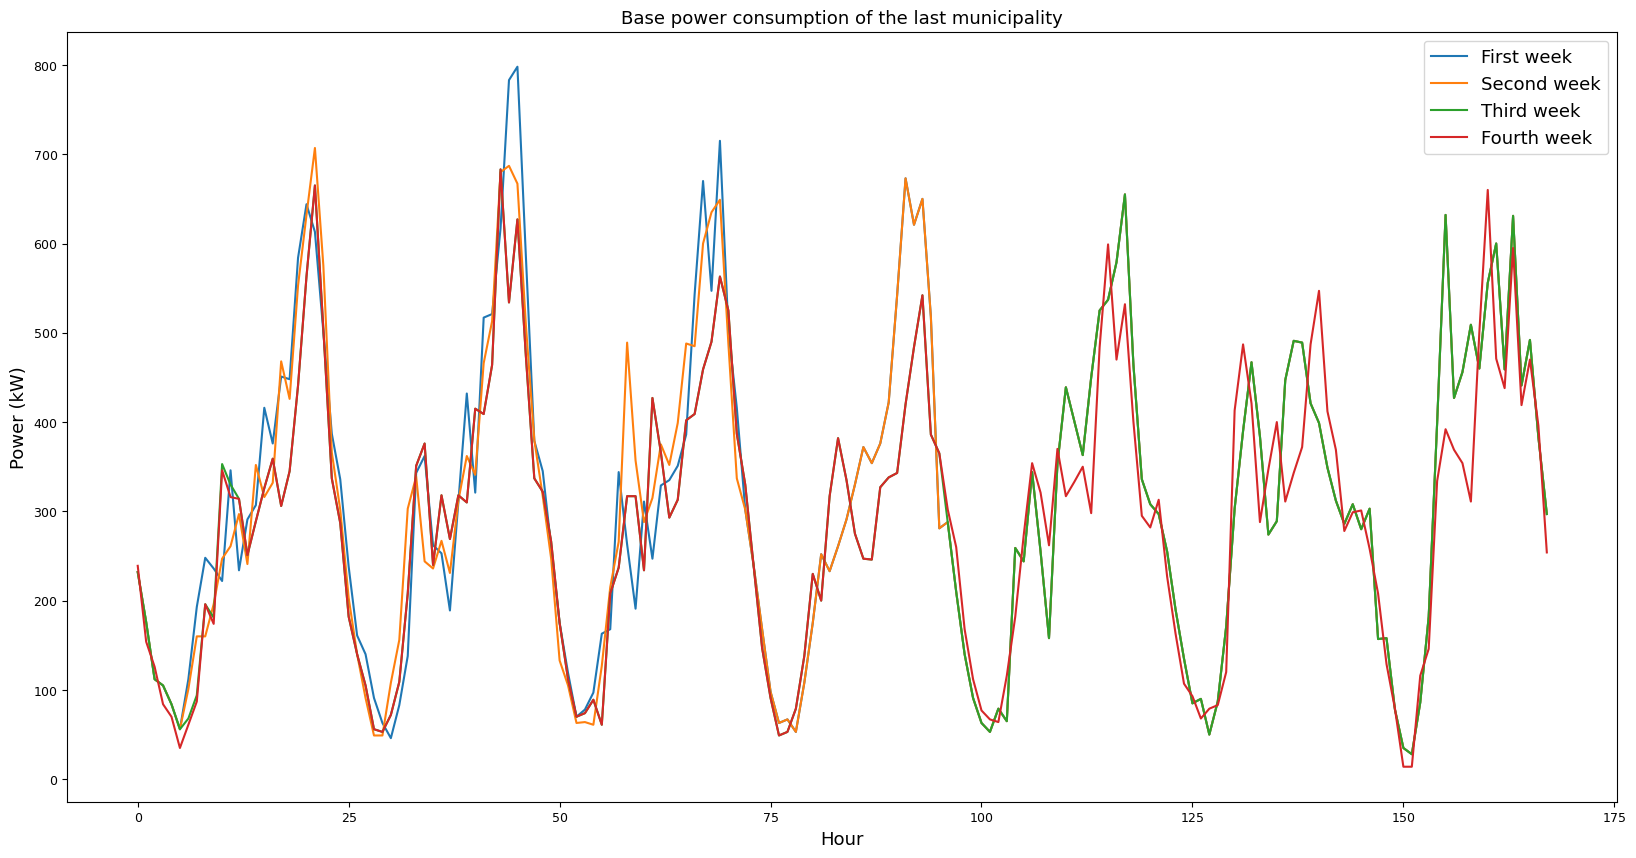

In [13]:
df_power_example = df_power[df_power['BFS']==df_power['BFS'].values[-1]].copy()
# The last municipality is selected as an example to show the data.
weeks = ['First', 'Second', 'Third', 'Fourth']
plt.figure(figsize=(20, 10))
for i, week in enumerate(weeks):
    plt.plot(df_power_example[df_power_example['week']==i+1]['CP_value'].values, label = '{} week'.format(week))
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Base power consumption of the last municipality')
plt.legend()
plt.show()

# Step 3: Load allocation
Consider that the EV power consumption is distributed proportionately to the conventional load of the LV nodes in the given municipalities. Get the maximum value of CP (base EV consumption) and PD (upper EV power consumption).\
With these values, obtain the nodal distribution of maximum CP consumption and maximum PD consumption.  Get statistical descriptors of these distributions for the municipalities. 

All EV consumption is assumed to be supplied by LV grids. Within each municipality, consumption is allocated proportionally based on the conventional demand share at each node. Importantly, the allocation is only done for grids with edge files. For example, Municipality 715 contains only one grid with a single node without an edge. To prevent extreme allocation scenarios, grids with only one node are excluded from the allocation process, and the EV consumption for Municipality 715 is disregarded.

For instance, in Municipality 1, with 5 grids and a total of 818 nodes, the demand share for each node is calculated using Eq. (1), where $i$ represents the node index, $j$ represents the BFS number of the municipality and $t$ represents time step. Subsequently, the CP value for each node is determined using Eq. (2). The same approach applies to other parameters, such as PD, PU, FE, and EP.

\begin{equation}
    \text{share}_{ij} = \frac{\text{dmd}_{ij}}{\sum_{i=1}^N \text{dmd}_{ij}} \tag{1}
\end{equation}

\begin{equation}
    \text{CPshare}_{ijt} = CP_{jt} \cdot \text{share}_{ij} \tag{2}
\end{equation}

In [14]:
# Function: concat_all_grids
# **Description**:
# This function aggregates node-level data for a set of grids, calculating the demand (`el_dmd`) 
# and its percentage contribution relative to the total demand across all grids.

# **Arguments**:
# - `grid_ids` (list): A list of grid IDs to process. Each ID represents a grid, and IDs without an underscore are skipped.
# - `path` (str): The directory path where node files for each grid are located. Each node file is expected to be a GeoDataFrame.

# **Returns**:
# - `node_total` (pd.DataFrame): A DataFrame containing the following columns:
#   - `grid_name`: The name of the grid.
#   - `node_name`: The node identifier (from the 'osmid' column).
#   - `dmd`: The demand at the node (from the 'el_dmd' column, defaulted to 0 if missing).
#   - `percentage`: The percentage of the node's demand relative to the total demand across all nodes in all grids.
# - If no valid grids are found, an empty DataFrame is returned.

# **Additional Notes**:
# - For grids missing the 'osmid' column, the function skips processing.
# - The `el_dmd` column is initialized to zero for grids where it is not present.
# - The function prints a message when encountering single-node grids or empty grids.

def concat_all_grids(grid_ids, path):
    node_total_list = [ ]
    for n in range(len(grid_ids)):
        i = grid_ids[n]
        if '_' not in i:
            print('Single node, skip grid:', i)
            continue
        node_id = i+"_nodes"
        node = gpd.read_file(path+node_id)
        if 'el_dmd' not in node.columns:
            node['el_dmd'] = 0
        dmd = node['el_dmd']
        if 'osmid' not in node.columns:
            continue    
        grid_name = i
        node_name = node['osmid']
        node_total_list.append(pd.DataFrame({'grid_name':grid_name, 'node_name':node_name, 'dmd':dmd}))
    if len(node_total_list) == 0:
        return pd.DataFrame()
    node_total = pd.concat(node_total_list, ignore_index=True)
    node_total['dmd'] = node_total['dmd'].astype(float)
    node_total['percentage'] = node_total['dmd']/node_total['dmd'].sum()
    return node_total

The dataframe `node_total` has the conventional load information of the LV nodes contained within a given municipality. The percentage of the conventional load that they consume in the given municipality is assigned to a column named 'percentage'. This percentage is scaled by the maximum CP, PU and PD in the municipality profiles. Their results are stored in 'CP_max', 'PU_max', and 'PD_max'.

In addition, `statistics` has statistics about the EV load assigned to each grid. The columns of the file are:
- 'BFS': The BFS number, which indicates the municipality.
- 'median': The median conventional load percentage that nodes with consumption have, i.e., nodes with load above 0.
- 'deviation': The standard deviation of conventional load percentage that nodes with consumption have, i.e., nodes with load above 0.
- '90th quantile': The 90th quantile of load percentage.
- '95th quantile': The 90th quantile of load percentage.
- '99th quantile': The 90th quantile of load percentage.
- 'CP_max': The sum of the maximum base EV power consumption for the nodes contained in the grid. 
- 'PU_max': The sum of the maximum upper EV power consumption for the nodes contained in the grid. 
- 'max_percentage': maximum nodal percentage of the total conventional load of the municipality.
- 'min_percentage': minimum nodal percentage of the total conventional load of the municipality.

In [22]:
mother_path = os.path.dirname(base_path)
LV_data_path = os.path.join(mother_path, 'LV/')
dict_path = os.path.join(mother_path, 'data_processing')
save_path = os.path.join(base_path, 'EV_output','EV_percentage')

with open(os.path.join(dict_path, 'dict_folder.json')) as f:    
    dictionary = json.load(f)
len_dict = len(dictionary)
keys = list(dictionary.keys())

statistics_list = []

CP_max_values = df_power.groupby('BFS')['CP_value'].max().copy()
PU_max_values = df_power.groupby('BFS')['PU_value'].max().copy()
PD_max_values = df_power.groupby('BFS')['PD_value'].max().copy()
node_profiles_list = []


for key in tqdm.tqdm(keys):
    path = LV_data_path+dictionary[key]+'/'
    grid_ids = list(set([f[:-6] for f in os.listdir(path) if f.startswith(key+'-')]))
    node_total = concat_all_grids(grid_ids,path)
    if node_total.empty:
        print('Empty grid:', key)
        continue
    node_total_test = node_total[node_total['dmd']>0]
    CP_max = CP_max_values.loc[int(key)]
    PU_max = PU_max_values.loc[int(key)]
    PD_max = PD_max_values.loc[int(key)]
    
    statistics_list.append(pd.DataFrame({'BFS':key, 
                                                      'median':node_total_test['percentage'].median(), 
                                                      'deviation':node_total_test['percentage'].std(),
                                                        '90th quantile':node_total_test['percentage'].quantile(0.9),
                                                        '95th quantile':node_total_test['percentage'].quantile(0.95),
                                                        '99th quantile':node_total_test['percentage'].quantile(0.99),
                                                        'CP_max':CP_max,
                                                        'PU_max':PU_max,
                                                        'max_percentage':node_total['percentage'].max(),
                                                        'min_percentage':node_total['percentage'].min()}, index=[0]))
    
    node_total['CP_max'] = CP_max*node_total['percentage']
    node_total['PU_max'] = PU_max*node_total['percentage']
    node_total['PD_max'] = PD_max*node_total['percentage']
    node_total['BFS'] = int(key)
    node_profiles_list.append(node_total)

node_profiles = pd.concat(node_profiles_list, ignore_index=True)
node_profiles['grid_name'] = node_profiles['grid_name'].astype(str)
node_profiles['node_name'] = node_profiles['node_name'].astype(str)
node_profiles.sort_values(['BFS','grid_name','node_name'], ascending=True, inplace=True)
node_profiles.to_parquet(os.path.join(save_path, 'node_profiles.parquet'))
statistics = pd.concat(statistics_list, ignore_index=True)
statistics.to_csv(save_path+'/statistics.csv', index=False)

 22%|██▏       | 474/2148 [01:27<48:01,  1.72s/it]

Single node, skip grid: 261-990


 25%|██▍       | 533/2148 [01:38<03:11,  8.45it/s]

Single node, skip grid: 2831-15


 30%|███       | 649/2148 [01:52<04:51,  5.14it/s]

Single node, skip grid: 3105-2


 35%|███▌      | 755/2148 [02:19<18:52,  1.23it/s]

Single node, skip grid: 3513-2


 38%|███▊      | 812/2148 [02:31<03:32,  6.29it/s]

Single node, skip grid: 3746-20


 40%|████      | 862/2148 [02:39<04:44,  4.53it/s]

Single node, skip grid: 3921-2


 47%|████▋     | 1009/2148 [02:59<01:50, 10.35it/s]

Single node, skip grid: 4170-22


 62%|██████▏   | 1336/2148 [03:43<02:49,  4.78it/s]

Single node, skip grid: 5401-31


 70%|███████   | 1512/2148 [04:02<00:45, 13.92it/s]

Single node, skip grid: 5675-8


 79%|███████▊  | 1691/2148 [04:19<01:01,  7.38it/s]

Single node, skip grid: 6022-58


 90%|█████████ | 1943/2148 [05:06<00:14, 13.97it/s]

Single node, skip grid: 6743-14


 93%|█████████▎| 1993/2148 [05:10<00:11, 13.73it/s]

Single node, skip grid: 715-1
Empty grid: 715


 96%|█████████▌| 2064/2148 [05:19<00:07, 11.80it/s]

Single node, skip grid: 879-21


100%|██████████| 2148/2148 [05:30<00:00,  6.50it/s]


# Step 4: Distribution analysis

high deviation: the percentages allocated to modes are imbalance
high CP_max: the maximum power consumption in this grid is much higher than other grid.

After allocating EV consumption to LV grids, we analyzed the statistical distribution of consumption per node and per grid across nine zones, categorized as periurban, rural, and urban areas within the Alps, Jura, and Midlands regions.

In [23]:
def hist_in_zone(data, zone, zone_municipality):
    zone_name = zone
    zone_data = zone_municipality[zone_municipality['zone']==zone_name].copy()
    zone_data['municipality'] = zone_data['municipality'].astype('int')
    zone_muni = zone_data['municipality'].values
    data = data[data['BFS'].isin(zone_muni)].copy()
    data.reset_index(drop=True, inplace=True)
    return data

In [24]:
zone_municipality_list = []
for key in dictionary.keys():
    zone = dictionary[key]
    municipality = key
    zone_municipality_list.append(pd.DataFrame({'zone':zone, 'municipality':municipality}, index=[0]))
zone_municipality = pd.concat(zone_municipality_list, ignore_index=True)

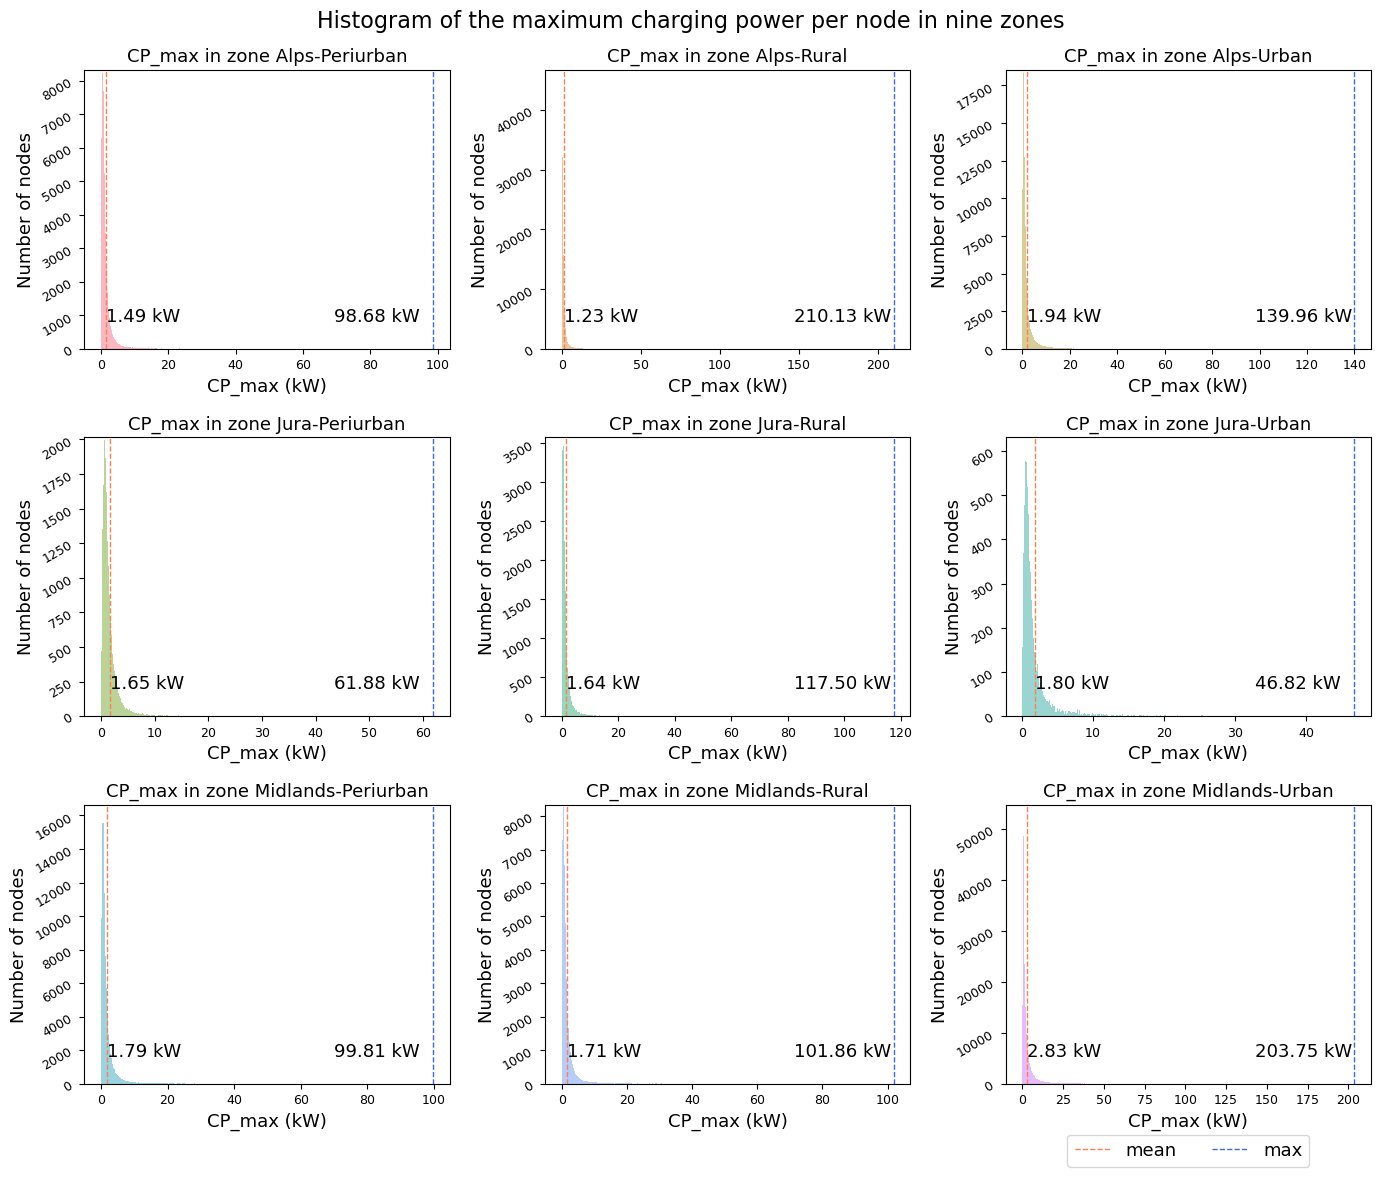

In [25]:
# we rename the column '9_CAT' to 'zone'
zones.rename(columns={'9_CAT':'zone'}, inplace=True)
unique_zones = zones['zone'].unique()

data_nodes = pd.read_parquet(save_path+'/node_profiles.parquet')

# data to look at
column = 'CP_max'

plt.figure(figsize=(14, 12))
unique_zones.sort()
for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone(data_nodes, zone, zone_municipality)
    data = data[data[column]>0]
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=1200, alpha=0.5,  color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1, label='mean')
    
    max = data[column].max()
    plt.axvline(max, color='royalblue', linestyle='dashed', linewidth=1, label='max')
    plt.xlabel(f'{column} (kW)')
    plt.ylabel('Number of nodes')
    # get the max count of the histogram
    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.7*max, 0.1*max_count, f'{max:.2f} kW', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} kW', rotation=0)
    plt.title(f'{column} in zone {zone}')
    # rotate y ticks
    plt.yticks(rotation=30)
# put the legend outside the plot, under the x-axis, and remove the frame, in the middle of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.suptitle('Histogram of the maximum charging power per node in nine zones', fontsize=16)
plt.tight_layout()  
if not os.path.exists(os.path.join(base_path, 'plots')):
    os.makedirs(os.path.join(base_path, 'plots'))
plt.savefig(os.path.join(base_path, 'plots', f'{column}_histogram.png'), dpi = 300, bbox_inches='tight')  
plt.show()

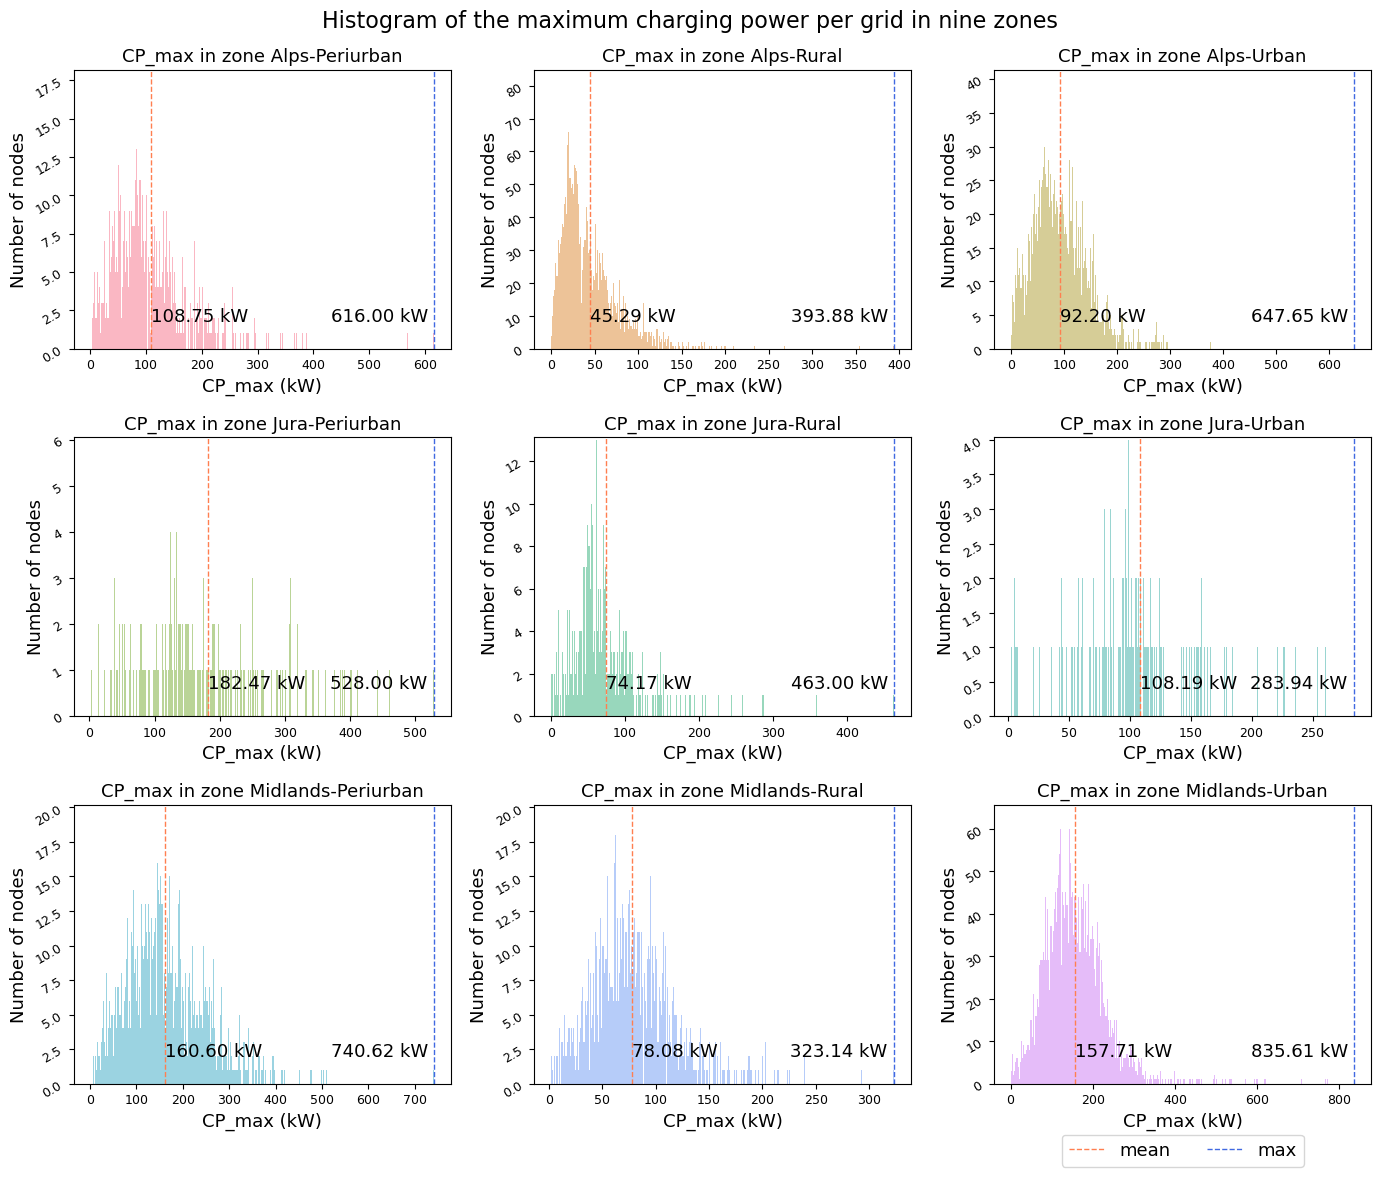

In [26]:
plt.figure(figsize=(14, 12))
for i in range(len(unique_zones)):
    zone = unique_zones[i]
    data = hist_in_zone(data_nodes, zone, zone_municipality)
    # group by grid_name, delete node_name
    data = data.drop(columns=['node_name']).groupby('grid_name').sum()
    data.reset_index(inplace=True)
    
    plt.subplot(3, 3, i+1)
    counts, bins, patches = plt.hist(data[column], bins=1200, alpha=0.5,  color=colors[i])
    mean = data[column].mean()
    plt.axvline(mean, color='coral', linestyle='dashed', linewidth=1, label='mean')
    
    max = data[column].max()
    plt.axvline(max, color='royalblue', linestyle='dashed', linewidth=1, label='max')
    plt.xlabel(f'{column} (kW)')
    plt.ylabel('Number of nodes')

    max_count = counts.max()
    plt.ylim(0, max_count*1.01)
    plt.text(0.7*max, 0.1*max_count, f'{max:.2f} kW', rotation=0)
    plt.text(mean, 0.1*max_count, f'{mean:.2f} kW', rotation=0)
    plt.title(f'{column} in zone {zone}')
    plt.yticks(rotation=30)
# put the legend outside the plot, under the x-axis, and remove the frame, in the middle of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.suptitle('Histogram of the maximum charging power per grid in nine zones', fontsize=16)
plt.tight_layout()  
plt.savefig(os.path.join(base_path, 'plots', f'{column}_histogram_grid.png'), dpi = 300, bbox_inches='tight')
plt.show()